In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn import metrics
%matplotlib inline
sns.set()

In [2]:
from sklearn.model_selection import learning_curve
from sklearn.metrics import plot_roc_curve
sns.set_style('whitegrid')

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier

In [4]:
tf_df = pd.read_csv('../train_features.csv',index_col='sig_id')

In [5]:
pca = PCA(n_components=50)
pca.fit(tf_df.loc[:,'g-0':'c-99'])
pca.explained_variance_ratio_

array([0.41821179, 0.03871707, 0.02358361, 0.02074852, 0.01890126,
       0.01715049, 0.01382442, 0.01341586, 0.00987961, 0.00873211,
       0.00841602, 0.00780523, 0.0066486 , 0.005899  , 0.00580112,
       0.00560802, 0.00517967, 0.0047722 , 0.0047209 , 0.00426508,
       0.00396959, 0.00371703, 0.00340236, 0.00314083, 0.00311071,
       0.00292178, 0.00282075, 0.00268926, 0.00262017, 0.00252039,
       0.00234754, 0.0022675 , 0.00222975, 0.00213984, 0.00210226,
       0.00200995, 0.00199031, 0.00192252, 0.00187064, 0.00180094,
       0.00175324, 0.00168294, 0.00165424, 0.00164389, 0.00161187,
       0.00159347, 0.00155125, 0.00153726, 0.00151427, 0.00148163])

Large drops after 2, 6, 8, 12 components.

In [6]:
reduced_comps = pca.transform(tf_df.loc[:,'g-0':'c-99'])
reduced_comps.shape

(23814, 50)

In [7]:
reduced_comps = reduced_comps[:,:6]
reduced_comps.shape

(23814, 6)

In [8]:
tts_df = pd.read_csv('../train_targets_scored.csv',index_col='sig_id')
moa1 = tts_df.iloc[:,0]
print(moa1.head())

sig_id
id_000644bb2    0
id_000779bfc    0
id_000a6266a    0
id_0015fd391    0
id_001626bd3    0
Name: 5-alpha_reductase_inhibitor, dtype: int64


In [9]:
tts_df.columns

Index(['5-alpha_reductase_inhibitor', '11-beta-hsd1_inhibitor',
       'acat_inhibitor', 'acetylcholine_receptor_agonist',
       'acetylcholine_receptor_antagonist', 'acetylcholinesterase_inhibitor',
       'adenosine_receptor_agonist', 'adenosine_receptor_antagonist',
       'adenylyl_cyclase_activator', 'adrenergic_receptor_agonist',
       ...
       'tropomyosin_receptor_kinase_inhibitor', 'trpv_agonist',
       'trpv_antagonist', 'tubulin_inhibitor', 'tyrosine_kinase_inhibitor',
       'ubiquitin_specific_protease_inhibitor', 'vegfr_inhibitor', 'vitamin_b',
       'vitamin_d_receptor_agonist', 'wnt_inhibitor'],
      dtype='object', length=206)

In [10]:
len(moa1[moa1==1])

17

In [11]:
logit_model = LogisticRegression(penalty='l1',solver='saga',max_iter=5000)
logit_model.fit(reduced_comps,moa1)
logit_model.score(reduced_comps,moa1)

0.9992861342067691

In [12]:
metrics.log_loss(moa1,logit_model.predict(reduced_comps))

0.02465605100837765

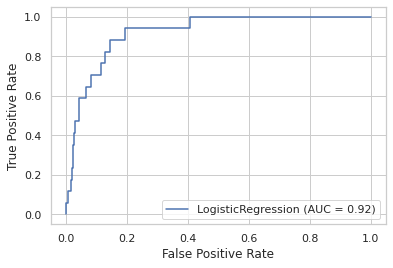

In [13]:
ax = plt.gca()
plot_roc_curve(logit_model,reduced_comps,moa1,ax=ax)
plt.show()

In [23]:
multilogistic_model = MultiOutputClassifier(LogisticRegression(penalty='l1',solver='saga',max_iter=5000))
multilogistic_model.fit(reduced_comps,tts_df)
tts_pred = multilogistic_model.predict(reduced_comps)
print(multilogistic_model.score(reduced_comps,tts_df))
metrics.log_loss(tts_df,tts_pred)

/home/paulus/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/paulus/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/paulus/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/paulus/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/paulus/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: Convergenc

0.42857142857142855


3.5701339864737314

In [25]:
metrics.log_loss(moa1,tts_pred[:,0])

0.02465605100837765

Interesting. So it happens that we can predict column 1 quite well, but on average, worse than 43%.

No wonder they want people pulling out deep learning to attack this.

Would be good to cycle through the whole list and see which columns perform how.

Oh, and very interesting to see if any of the PCA components got zero coefficients under L1 regularization... for each target... that's a lot to check.